<a href="https://colab.research.google.com/github/koshkit/VKR/blob/pre_release/PreRelease_Ensemble_Xception_ETU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#==============DATA_PRE-PROCESSING==========================#
import os
import random
import glob
import numpy as np
from numpy.ma.core import size
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#set path to dirs
dir_covid = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/COVID'
dir_opacity = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/Lung_Opacity'
dir_normal = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/Normal'
dir_pneumonia = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/Viral_Pneumonia'

#arrays dirs and classes
dir_list=[dir_covid, dir_opacity, dir_normal, dir_pneumonia]
classes=['covid', 'lung_opacity', 'normal', 'pneumonia']

In [2]:
#check dataset for integrity
filepaths=[]
labels=[]
for d,c in zip(dir_list, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  21165    labels:  21165


In [3]:
#create DataFrame
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=DataFrame(np.array(df).reshape(len(labels),2), columns = ['file_paths', 'labels'])

normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: labels, dtype: int64


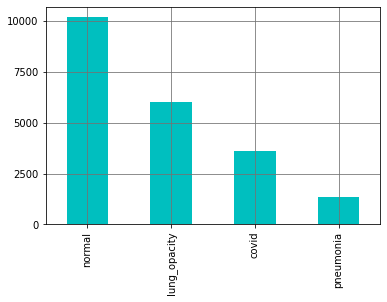

In [4]:
#print and plot df params
print(df['labels'].value_counts())
df['labels'].value_counts().plot(kind="bar", color = "c")
plt.rc('font',size=20)
plt.grid(True, c="0.45")
plt.show()

In [5]:
#get class image index
normal_count = df['labels'].value_counts()[0]
lung_opacity_count = df['labels'].value_counts()[1]
covid_count = df['labels'].value_counts()[2]
pneumonia_count = df['labels'].value_counts()[3]
normal_image_max_index = (df.labels.values == 'normal').argmax()
print(normal_image_max_index)
lung_opacity_max_index = (df.labels.values == 'lung_opacity').argmax()
print(lung_opacity_max_index)

9628
3616


In [6]:
#drop rows from df to 'covid' count
for i in range(normal_count - covid_count):
    df = df.drop([normal_image_max_index + i])
    
for n in range(lung_opacity_count - covid_count):
    df = df.drop([lung_opacity_max_index + n])

df['labels'].value_counts()

covid           3616
lung_opacity    3616
normal          3616
pneumonia       1345
Name: labels, dtype: int64

In [7]:
#add Chest X-Ray Images (Pneumonia) Dataset
filepaths=[]
labels=[]
for file in glob.glob('/content/drive/MyDrive/Colab_Notebooks/PNEUMONIA/*.jpeg'):
    filepaths.append(file)
    labels.append('pneumonia')
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  3875    labels:  3875


In [8]:
#create extra df
fseries = pd.Series(filepaths, name='file_name', dtype='str')
lseries = pd.Series(labels, name='label', dtype='str')
extra_df = pd.concat([fseries, lseries], axis=1)
extra_df = DataFrame(np.array(extra_df).reshape(len(labels),2), columns = ['file_paths', 'labels'])
extra_df.head()

,file_paths,labels
0,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
1,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
2,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
3,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
4,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia


In [9]:
#merge df with extra_df
df=pd.concat([df,extra_df], axis=0)
df=df.reset_index()
df['labels'].value_counts()
df.head()

,index,file_paths,labels
0,0,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
1,1,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
2,2,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
3,3,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
4,4,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid


In [10]:
pneumonia_count_upd = pneumonia_count + len(labels)
pneumonia_max_index=(df.labels.values == 'pneumonia').argmax()
print(pneumonia_max_index)

10848


In [11]:
#drop surplus pneumonia
for i in range(pneumonia_count_upd - covid_count):
    df = df.drop([pneumonia_max_index + i])

covid           3616
lung_opacity    3616
normal          3616
pneumonia       3616
Name: labels, dtype: int64


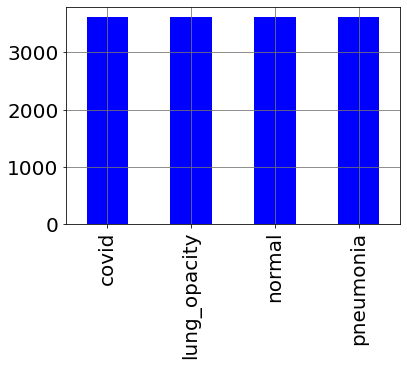

In [12]:
#plot current dataset state
print(df['labels'].value_counts())
df['labels'].value_counts().plot(kind="bar", color = "b")
plt.rc('font',size=20)
plt.grid(True, c="0.45")
plt.show()
#------------------DATA_PRE-PROCESSING---------------------------#

In [14]:
target_size=(299,299)
batch_size=16

In [15]:
train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, preprocessing_function=tf.keras.applications.xception.preprocess_input, validation_split=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state = 357)
train_set = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical', subset='training')
valid_set = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical', subset='validation')
test_set = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical')
test_x, test_y = next(test_set)

Found 10414 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
Found 2893 validated image filenames belonging to 4 classes.


In [16]:
train_df.head()

,index,file_paths,labels
3821,6217,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,lung_opacity
15765,3572,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
7409,16381,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,normal
9255,18227,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,normal
16021,3828,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia


In [17]:
test_df.head()

,index,file_paths,labels
13991,1798,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
1157,1157,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
7848,16820,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,normal
5296,7692,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,lung_opacity
2527,2527,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid


In [18]:
print(test_df['labels'].value_counts())

normal          738
lung_opacity    736
covid           717
pneumonia       702
Name: labels, dtype: int64


In [19]:
print(train_df['labels'].value_counts())
#------------------DIVIDE_DATA_SET------------------------------#

pneumonia       2914
covid           2899
lung_opacity    2880
normal          2878
Name: labels, dtype: int64


In [20]:
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

In [22]:
input_shape = (299,299,3)
classifier_activation='softmax'
classes=4
batch_size = 16
learning_rate = 0.0001
epochs = 20
callbacks = None

base_model = Xception(include_top = False, weights="imagenet", input_shape = input_shape)

In [23]:
x = base_model.output

In [24]:
model = tf.keras.Sequential([
    base_model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(256, activation='relu'), tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.2), tf.keras.layers.Dense(classes, activation='softmax')
])
lr=0.001

In [28]:
model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [26]:
patience = 1
stop_patience = 5
factor = 0.5

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [ ]:
results = model.fit(train_set, epochs = epochs,
                        validation_data = valid_set, 
                        batch_size = batch_size, 
                        callbacks = callbacks
                        )

Epoch 1/20
651/651 [==============================] - 429s 651ms/step - loss: 0.3763 - accuracy: 0.8611 - val_loss: 0.9870 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 2/20
651/651 [==============================] - 421s 646ms/step - loss: 0.2586 - accuracy: 0.9095 - val_loss: 0.6292 - val_accuracy: 0.7934 - lr: 0.0010
Epoch 3/20
651/651 [==============================] - 424s 651ms/step - loss: 0.2088 - accuracy: 0.9265 - val_loss: 0.2891 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 4/20
651/651 [==============================] - 424s 651ms/step - loss: 0.2024 - accuracy: 0.9303 - val_loss: 0.2691 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 5/20
651/651 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9389
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
651/651 [==============================] - 420s 644ms/step - loss: 0.1714 - accuracy: 0.9389 - val_loss: 0.4763 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 6/20
651/651 [========================

In [ ]:
model.summary()

In [ ]:
np.save('/content/sample_data/history_Xcep.npy', results.history)

In [ ]:
save_model = '/content/sample_data/Xcep.h5'
model.save(save_model)

In [ ]:
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
model.evaluate(test_set, verbose=2)

In [ ]:
model.predict()